# XGBoost model

In [290]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

import modify_dataset as md

In [291]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [292]:
df = pd.read_csv("dataset/preprocessed_train.csv")

In [293]:
# removing all rows for which store is closed
df = df[df.IsOpen == 1]

df.drop(['NumberOfCustomers','Date'], axis=1, inplace=True)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [294]:
#for now let's drop unusable categorical vars
df.drop(['StoreType','AssortmentType','Events'], axis=1, inplace=True)

In [295]:
df.head().T

,0,1,2,3,5
StoreID,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000
IsOpen,1.000000,1.000000,1.000000,1.000000,1.000000
HasPromotions,0.000000,0.000000,0.000000,0.000000,1.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,5676.000000,8111.000000,8300.000000,7154.000000,10110.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000


In [296]:
df.shape

(433958, 51)

In [297]:
train = md.get_fake_train3(df)

In [298]:
train.shape

(396528, 51)

In [299]:
test = md.get_fake_test3(df)
test.shape

(37430, 51)

In [300]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [301]:
train.head(10).T

,61,62,64,65,66,68,69,70,72,73
StoreID,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IsOpen,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
HasPromotions,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,8749.000000,11503.000000,10315.000000,10059.000000,6967.000000,7308.000000,7378.000000,7616.000000,8342.000000,6530.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000


In [302]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('IsOpen')
features.remove('D_DayOfweek')
#features.remove('Region')
#features.remove('Region_GDP')
features.remove('Max_Humidity')
features.remove('Min_Dew_PointC')
features.remove('Max_Wind_SpeedKm_h')
features.remove('Max_VisibilityKm')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Mean_Wind_SpeedKm_h')
features.remove('Events_Thunderstorm')
features.remove('Events_Fog')
#features.remove('Events_Snow') KEEP SNOW
#features.remove('Events_Rain') KEEP RAIN
features.remove('Events_Hail')


print("features")

pprint(features)

features
['IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_Dew_PointC',
 'Max_Sea_Level_PressurehPa',
 'Max_TemperatureC',
 'Mean_Dew_PointC',
 'Mean_Humidity',
 'Mean_Sea_Level_PressurehPa',
 'Mean_TemperatureC',
 'Mean_VisibilityKm',
 'Mean_Wind_SpeedKm_h',
 'Min_Humidity',
 'Min_Sea_Level_PressurehPa',
 'Min_TemperatureC',
 'Min_VisibilitykM',
 'Precipitationmm',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'Events_Rain',
 'Events_Snow',
 'MeanStoreSales',
 'MeanRegionSales',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin']


In [303]:
params = {
    "objective": "reg:linear",
    "eta": 0.2,
    "max_depth": 8,
    "subsample": 1.0,
    "colsample_bytree": 0.3, #0.3
    "silent": 1,
    "nthread":-1,
    #added as a test
    "eval_metric": "rmse",
    #"gamma": 2  #added as a test
}

#reg_alpha 
#reg_lambda
num_trees = 100 #400

In [304]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [305]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [306]:
X_train.shape

(376701, 51)

In [307]:
X_test.shape

(19827, 51)

In [308]:
#watchlist = [(dvalid, 'test'), (dtrain, 'train')]
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

In [309]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.3333	train-rmse:6.33491
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.06878	train-rmse:5.0707
[2]	test-rmse:4.05774	train-rmse:4.06018
[3]	test-rmse:3.25002	train-rmse:3.25189
[4]	test-rmse:2.60366	train-rmse:2.60576
[5]	test-rmse:2.08865	train-rmse:2.0901
[6]	test-rmse:1.67823	train-rmse:1.67927
[7]	test-rmse:1.3508	train-rmse:1.35152
[8]	test-rmse:1.09067	train-rmse:1.09136
[9]	test-rmse:0.882281	train-rmse:0.883084
[10]	test-rmse:0.719802	train-rmse:0.720363
[11]	test-rmse:0.588634	train-rmse:0.588727
[12]	test-rmse:0.483962	train-rmse:0.483658
[13]	test-rmse:0.405124	train-rmse:0.404342
[14]	test-rmse:0.345374	train-rmse:0.344246
[15]	test-rmse:0.299288	train-rmse:0.297833
[16]	test-rmse:0.263892	train-rmse:0.261813
[17]	test-rmse:0.240547	train-rmse:0.237933
[18]	test-rmse:0.221192	train-rmse:0.218021
[19]	test-rmse:0.209901	train-rmse:0.206396
[20]	te

### Validating

In [310]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.1182598473524923


RMSE

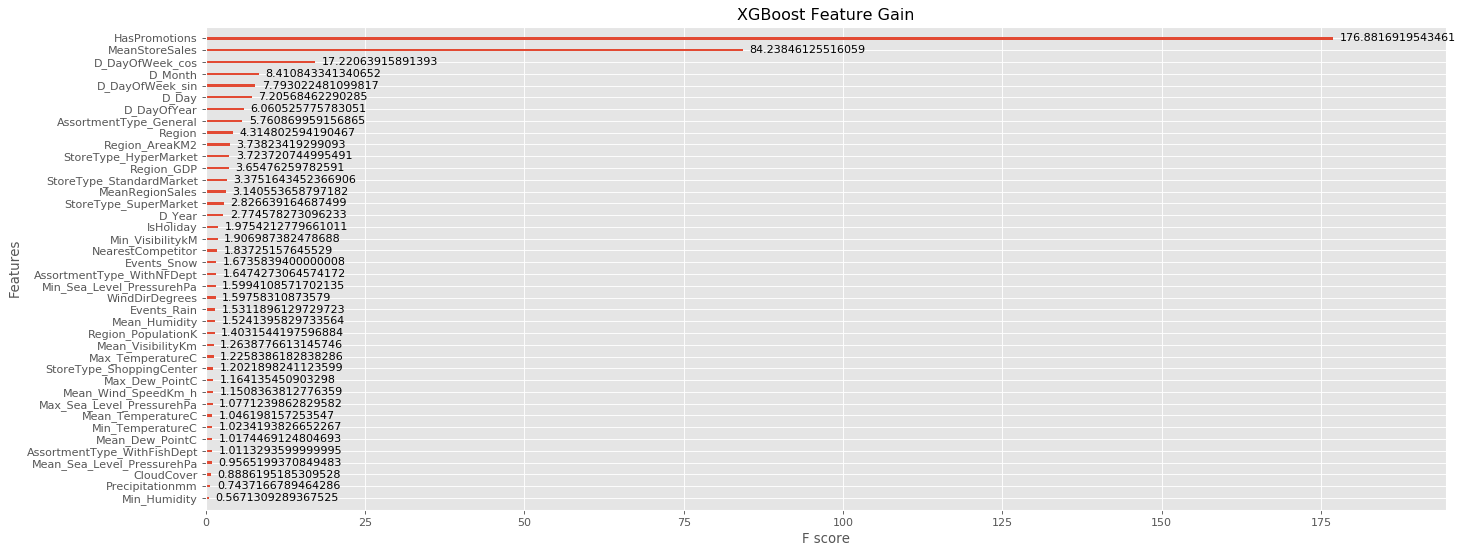

In [311]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80



# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

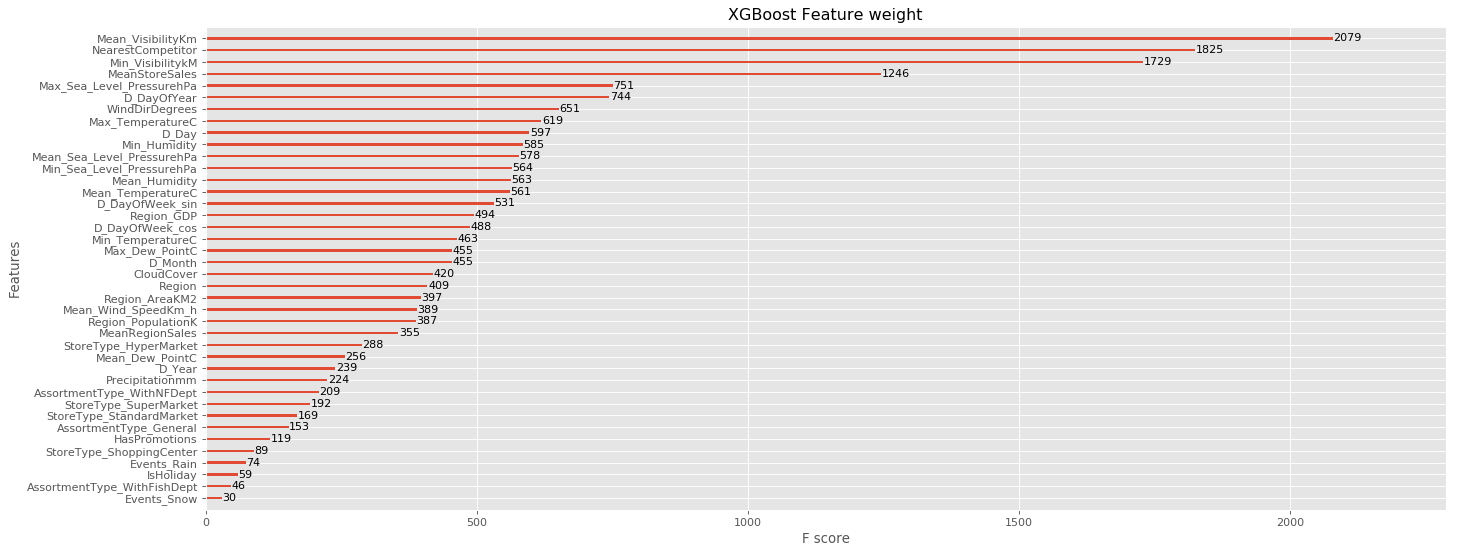

In [312]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

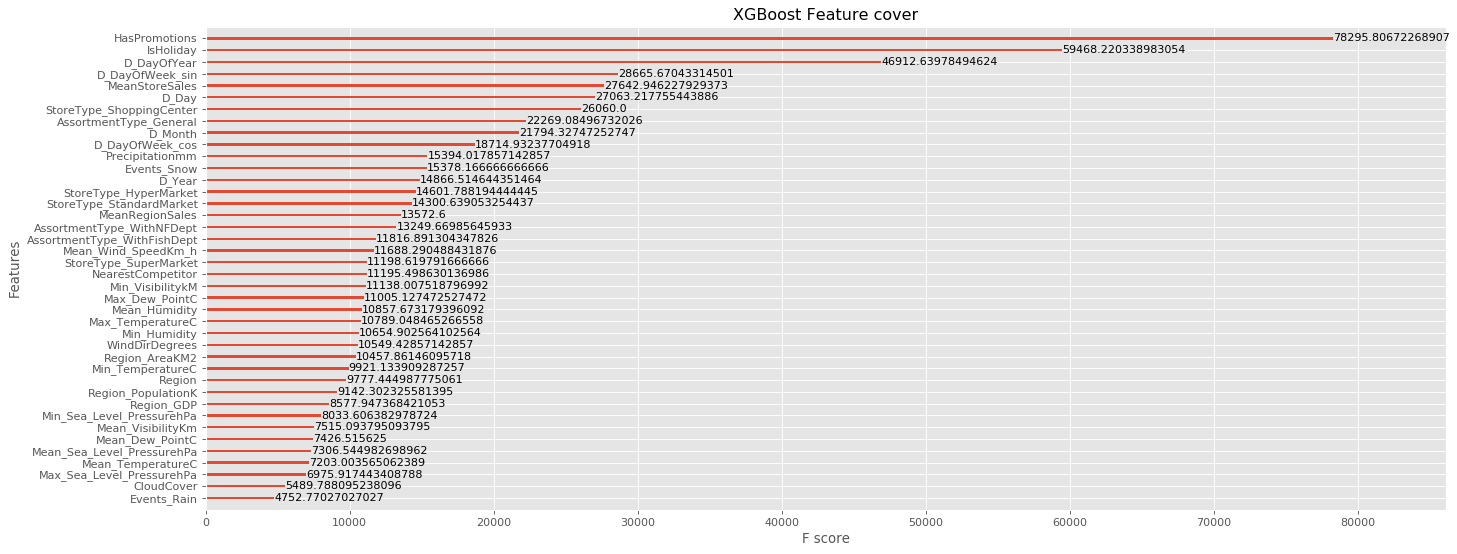

In [313]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [314]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [315]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [316]:
from BIP_error import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.07517844687533849


In [28]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [29]:
diff.head(15).T

670   -1279.332031
671    2576.285645
672     562.293457
674    -358.259277
675    -977.430664
677    -379.981445
678   -2131.573242
679   -1169.821289
680   -1505.702148
681    -186.675781
682     154.738281
684     439.338867
685     980.431641
686    -222.275879
687    -352.762207
dtype: float32

In [30]:
diff.mean()

-31.95819091796875

In [31]:
train_probs.shape

(36911,)

In [32]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [33]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [34]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [35]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.20526742155500666


In [36]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,7223.097656
14894,6795,7046.692383
14896,7035,6370.949219
14897,5437,5569.374023
14898,5725,5568.146973
14899,5143,5377.158203
14900,5589,5971.674316
14901,7520,6499.630859
14903,3927,5238.018555
14904,3682,4800.742676


In [37]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,7223.097656
14894,6795,7046.692383
14896,7035,6370.949219
14897,5437,5569.374023
14898,5725,5568.146973
14899,5143,5377.158203
14900,5589,5971.674316
14901,7520,6499.630859
14903,3927,5238.018555
14904,3682,4800.742676


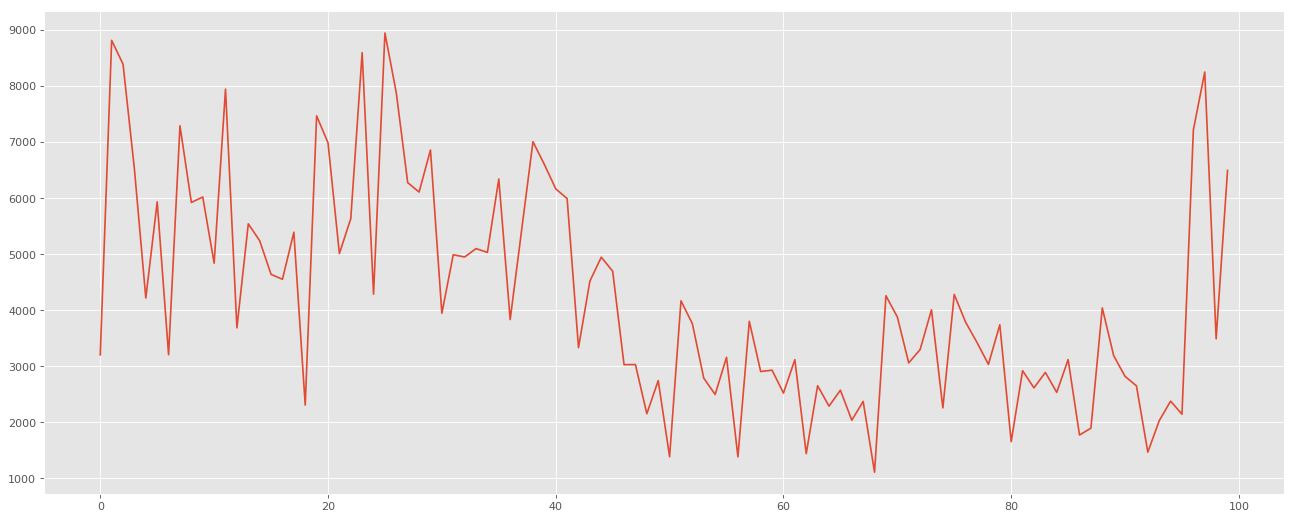

In [38]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

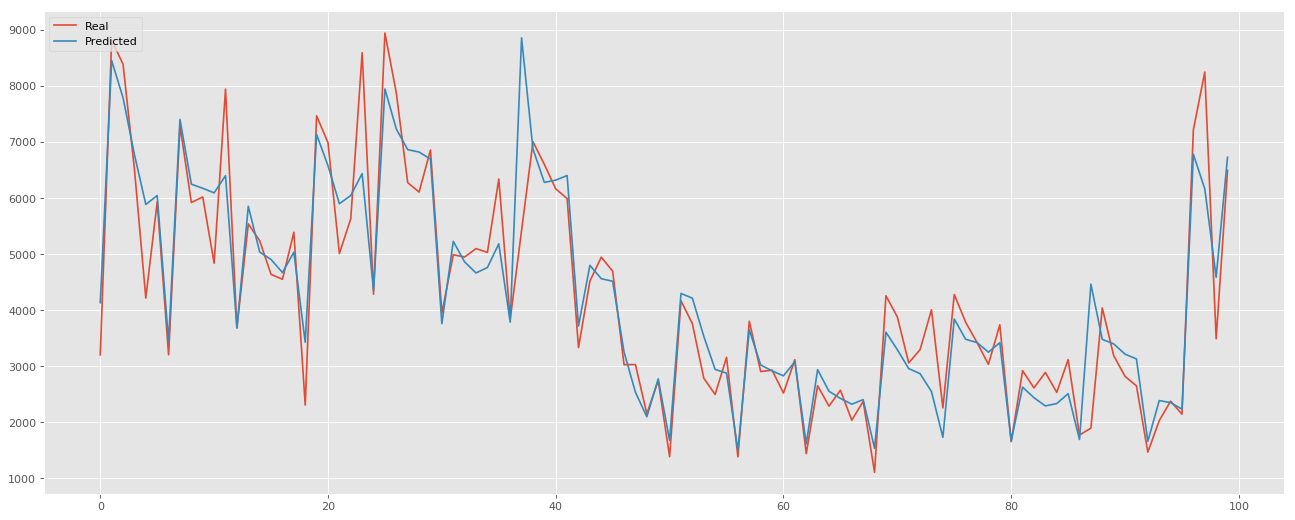

In [39]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

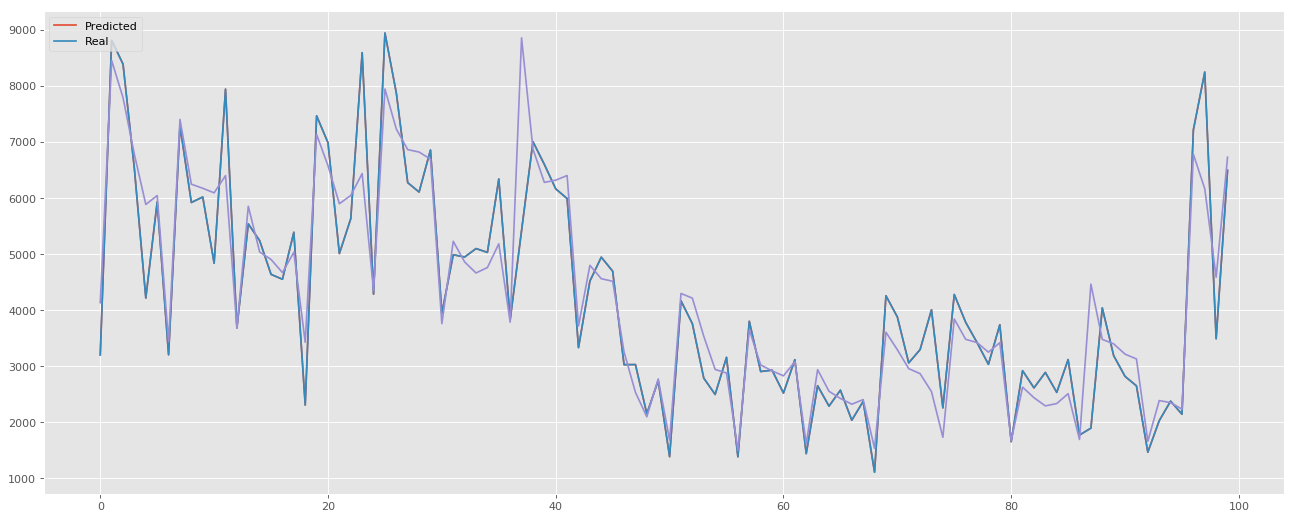

In [40]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [41]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

ValueError: operands could not be broadcast together with shapes (19853,) (36911,) 

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]